In [1]:
import requests
import io
import datetime

import numpy as np
import pandas as pd
import matplotlib.pylab as plt
plt.rcParams["figure.figsize"] = (8, 6)

In [2]:
import lightgbm as lgb
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.api as sm
from scipy import stats

In [3]:
INPUT_DIR = "input/"

In [4]:
valid_start = datetime.datetime(2019, 1, 1)
pred_start = datetime.datetime(2020, 1, 1)
pred_end = datetime.datetime(2021, 1, 1)

In [5]:
def plot_prediction(df_eval):
    actual = df_eval['y']
    pred = df_eval['pred']
    
    mape = (np.abs(pred - actual) / actual * 100).mean()

    actual.plot(label='actual')
    pred.plot(label=f'predict, MAPE:{mape:.2f} %')
    plt.legend()
    plt.show()
    
    (pred - actual).plot(label='residual')
    plt.legend()
    plt.show()

In [6]:
def correlation_plot(data, lags=60):
    fig = plt.figure(figsize=(10, 8))
    # 自己相関のコレログラム
    ax1 = fig.add_subplot(2, 1, 1)
    ax1.set_ylim(-1.1, 1.1)
    fig = sm.graphics.tsa.plot_acf(data, lags=lags, ax=ax1)
    # 偏自己相関のコレログラム
    ax2 = fig.add_subplot(2, 1, 2)
    ax2.set_ylim(-1.1, 1.1)    
    fig = sm.graphics.tsa.plot_pacf(data, lags=lags, ax=ax2)
    plt.show()

In [7]:
target = ['y']
features = []

df = pd.read_csv(INPUT_DIR + 'daily.csv')
df['ds'] = pd.to_datetime(df['date'])
df['y'] = df['power']

df_temperature = pd.read_csv(INPUT_DIR + 'daily_temperature.csv')
df_temperature['ds'] = pd.to_datetime(df_temperature['date'])
features.append('temperature')

df_gdp = pd.read_csv(INPUT_DIR + 'daily_gdp.csv')
df_gdp['ds'] = pd.to_datetime(df_gdp['date'])
features.append('gdp')

df = pd.merge(df[['ds', 'y']], df_temperature[['ds', 'temperature']], on='ds', how='left')
df = pd.merge(df, df_gdp[['ds', 'gdp']], on='ds', how='left')

df['week'] = df['ds'].dt.isocalendar().week.astype('int')
features.append('week')
df['dayofweek'] = df['ds'].dt.dayofweek
features.append('dayofweek')

for l in range(1,15):
    df[f'y_shift_{l}d'] = df['y'].shift(l).bfill()
    df[f't_shift_{l}d'] = df['temperature'].shift(l).bfill()
    features.append(f'y_shift_{l}d')
    features.append(f't_shift_{l}d')

In [8]:
df_train = df[(df['ds'] < valid_start)]
df_valid = df[(df['ds'] < pred_start) & (df['ds'] >= valid_start)]
df_test = df[(df['ds']>= pred_start) & (df['ds'] < pred_end)]

In [9]:
lgb_train = lgb.Dataset(df_train[features], df_train[target])
lgb_valid = lgb.Dataset(df_valid[features], df_valid[target])
lgb_test = lgb.Dataset(df_test[features], df_test[target])
# 評価基準を設定する 
params = {'metric' : 'rmse'}

In [10]:
model = lgb.train(params = params,
                  train_set = lgb_train,
                  num_boost_round = 1000,
                  valid_sets =lgb_valid,
                  verbose_eval=10,
                  early_stopping_rounds = 10
                 )

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7302
[LightGBM] [Info] Number of data points in the train set: 1005, number of used features: 32
[LightGBM] [Info] Start training from score 32.543366
Training until validation scores don't improve for 10 rounds
[10]	valid_0's rmse: 2.03173
[20]	valid_0's rmse: 1.38362
[30]	valid_0's rmse: 1.19611
[40]	valid_0's rmse: 1.12577
[50]	valid_0's rmse: 1.09951
[60]	valid_0's rmse: 1.08555
[70]	valid_0's rmse: 1.07488
[80]	valid_0's rmse: 1.06687
[90]	valid_0's rmse: 1.06481
[100]	valid_0's rmse: 1.06349
[110]	valid_0's rmse: 1.06074
[120]	valid_0's rmse: 1.05695
[130]	valid_0's rmse: 1.05334
[140]	valid_0's rmse: 1.05264
[150]	valid_0's rmse: 1.05119
[160]	valid_0's rmse: 1.04953
[170]	valid_0's rmse: 1.04983
[180]	valid_0's rmse: 1.0481
[190]	valid_0's rmse: 1.0479
[200]	valid_0's rmse: 1.04766
Early

In [11]:
eval_cols = target + ['ds']
df_eval = df_test[eval_cols].copy()
df_eval['pred'] = model.predict(df_test[features])
df_eval = df_eval.set_index('ds')

In [12]:
df_eval

,y,pred
ds,,
2020-01-01,27.447500,29.806744
2020-01-02,27.917917,30.065740
2020-01-03,28.255000,28.607811
2020-01-04,29.801667,26.930856
2020-01-05,31.040000,30.468800
...,...,...
2020-12-27,31.651250,31.694206
2020-12-28,32.922500,34.843983
2020-12-29,31.521250,34.409185


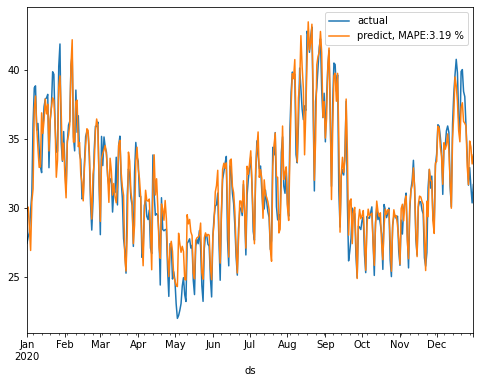

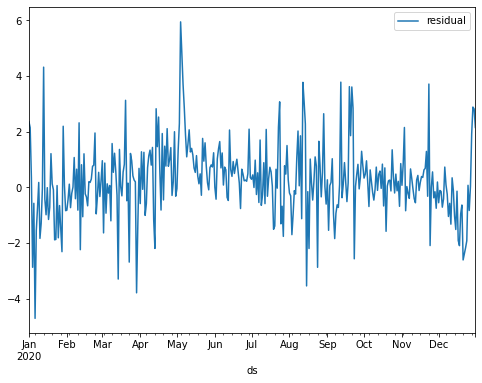

In [13]:
plot_prediction(df_eval)

## 残差の確認

Jack Bera: 	 Jarque_beraResult(statistic=58.85616193211517, pvalue=1.6575629757653587e-13)


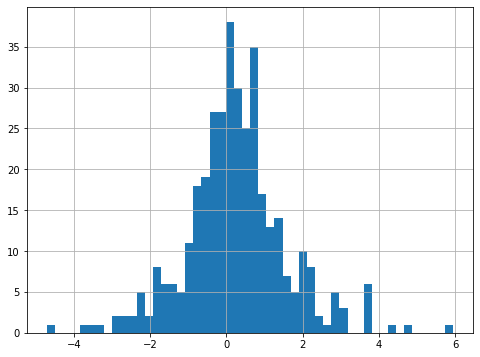

In [14]:
diff_arr = df_eval['pred'] - df_eval['y']

diff_arr.hist(bins=50)

jarque_bera_test = stats.jarque_bera(diff_arr)
print('Jack Bera:', '\t', jarque_bera_test)

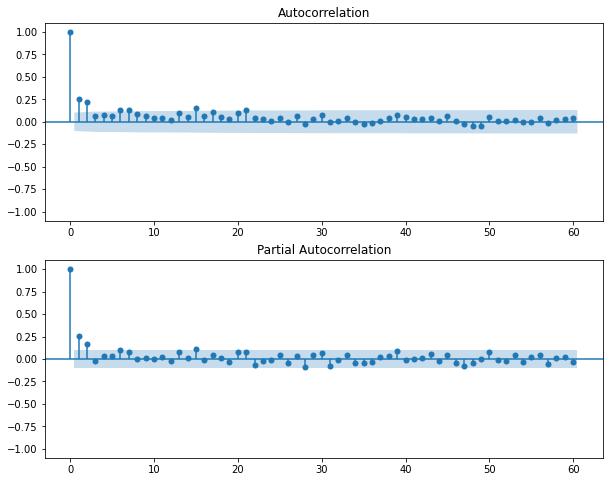

1 24.204495297610052 8.662984405502032e-07
2 42.79721380015356 5.08982795735095e-10
3 44.53400178148012 1.162233020533518e-09
4 46.80785550262764 1.6721031049336197e-09
5 48.245600904295046 3.1646194752843603e-09
6 54.46703065396719 5.938530145840185e-10
7 61.27014790935913 8.414410109068635e-11
8 63.85639498280898 8.119641666595247e-11
9 65.51915183739935 1.1432891133032404e-10
10 66.05690664297606 2.5434179441619227e-10


/home/ryoji/.cache/pypoetry/virtualenvs/timeseries-weK0nu0g-py3.8/lib/python3.8/site-packages/statsmodels/stats/diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


In [15]:
correlation_plot(diff_arr)

results = acorr_ljungbox(diff_arr, lags=10)
lag = 1
for lb, p in zip(results[0], results[1]):
    print(lag, lb, p)
    lag += 1

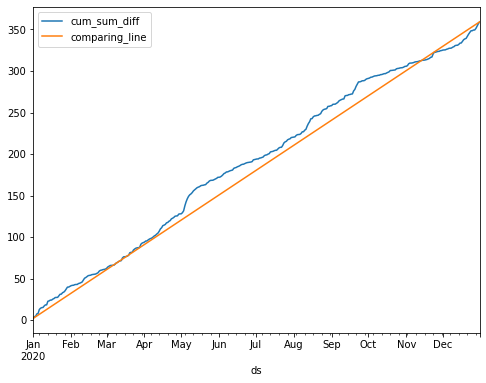

In [16]:
cum_arr = diff_arr.apply(np.abs).cumsum()

cum_min = cum_arr.min()
cum_max = cum_arr.max()

se_line = pd.Series(np.linspace(cum_min, cum_max, len(diff_arr)), index=diff_arr.index)

cum_arr.plot(label='cum_sum_diff')
se_line.plot(label='comparing_line')
plt.legend()
plt.show()

---ctt---
(-10.523393727669141, 2.74827538802062e-16, 1, 364, {'1%': -4.403242980856316, '5%': -3.848711170118675, '10%': -3.5633551124006564}, 1130.1518939348405)
---ct---
(-9.693469704964109, 1.0491527943709468e-14, 1, 364, {'1%': -3.983858492918219, '5%': -3.422620677558916, '10%': -3.13418338427965}, 1135.8332106236903)
---c---
(-9.714526656528722, 9.911112035168015e-17, 1, 364, {'1%': -3.4484434475193777, '5%': -2.869513170510808, '10%': -2.571017574266393}, 1134.3615601256765)
---nc---
(-4.581682102133556, 6.663795428284698e-06, 6, 359, {'1%': -2.5719959973929436, '5%': -1.9417736239465488, '10%': -1.6161006771222244}, 1136.6769964822515)


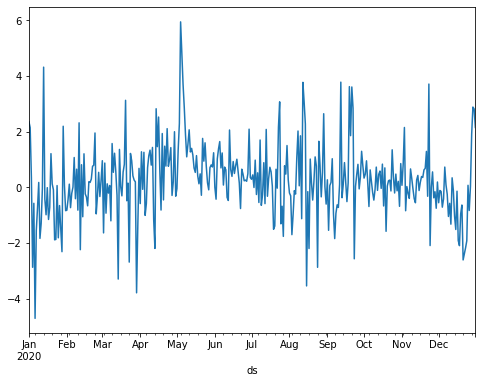

In [17]:
y = diff_arr
y.plot()
regs = ['ctt', 'ct', 'c', 'nc'] # 2次のトレンド＋定数項、1次のトレンド＋定数項, トレンドなし＋定数項、トレンド・定数項なし
for r in regs:
    print(f'---{r}---')
    print(sm.tsa.stattools.adfuller(y, regression=r))

##  特徴量重要度

In [18]:
importances = pd.DataFrame(model.feature_importance('gain'), index=features, columns=['gain'])
importances['split'] = model.feature_importance('split')

In [19]:
importances['gain'].sort_values(ascending=False)

y_shift_1d     61378.892485
dayofweek      12414.228692
temperature     9902.671633
y_shift_3d      2821.110197
y_shift_2d      1309.714976
week             676.827915
y_shift_11d      294.529122
y_shift_5d       287.247000
y_shift_14d      285.684616
y_shift_7d       275.443026
y_shift_13d      271.945821
t_shift_1d       256.189169
t_shift_6d       195.642560
y_shift_4d       191.529951
y_shift_6d       186.020326
y_shift_8d       175.344807
y_shift_10d      169.397019
t_shift_7d       158.088563
t_shift_4d       155.051684
t_shift_5d       154.458892
y_shift_9d       154.017587
t_shift_8d       133.652187
t_shift_3d       127.736674
t_shift_2d       121.238131
t_shift_13d       91.922679
t_shift_10d       84.173099
t_shift_11d       82.735609
t_shift_9d        63.168343
t_shift_12d       62.982697
y_shift_12d       60.776111
gdp               52.864648
t_shift_14d       51.108509
Name: gain, dtype: float64